# **CS 181 HW4 Problem 2**

Only code you have to write are places marked with a TODO comment.

#### Loading datasets for K-Means and HAC:

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.spatial import distance
import itertools

small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [116]:
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K
        self.centroids = None
        self.assignments = None
        self.history = []

    # X is a (N x 28 x 28) array where 28x28 is the dimensions of each of the N images.
    def fit(self, X):
        # Number of data points
        N = X.shape[0]
        
        # Reshape the data into 2D array
        X_flat = X.reshape(N, -1)
        
        # Randomly initialize cluster centroids
        centroids_indices = np.random.choice(N, self.K, replace=False)
        self.centroids = X_flat[centroids_indices]
        
        for _ in range(10):
            # Assign each data point to nearest centroid using L2 Norm
            clusters = np.argmin(np.linalg.norm(X_flat[:, np.newaxis, :] - self.centroids, axis = 2), axis = 1)
            
            # Objective function calculation
            objective = sum(np.min(np.linalg.norm(X_flat[:, np.newaxis, :] - self.centroids, axis = 2)**2, axis=1))
            self.history.append(objective)
            
            # Update centroids using mean
            new_centroids = np.array([np.mean(X_flat[clusters == k], axis = 0) for k in range(self.K)])
            
            # Check for convergence (if centroids do not change)
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
            self.assignments = clusters

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        return self.centroids
    
    # TODO: change this for part 1's plot
    def plot_verify_objective(self):
        plt.plot(self.history, marker='o')
        plt.title('K-Means Objective Function Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Residual Sum of Squares (RSS)')
        plt.grid(True)
        plt.show()
    
    # TODO: change this for part 5
    def get_cluster_sizes(self):
        _, counts = np.unique(self.assignments, return_counts=True)
        return counts

### Part 1: This takes seconds to run

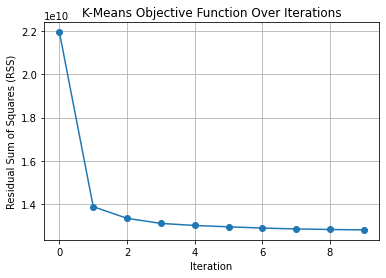

In [117]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

Plotting code for parts 2 and 3

In [118]:
def make_mean_image_plot(data, standardized = False):
    niters = 3
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()

### Part 2: This takes ~3 minutes to run

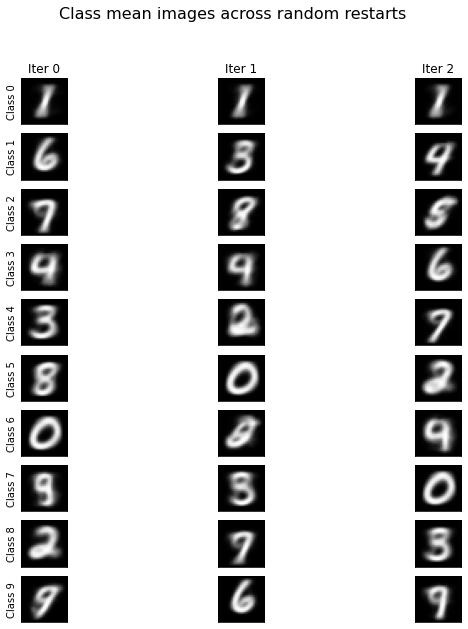

In [119]:
make_mean_image_plot(large_dataset)

### Part 3: This takes ~3 minutes to run

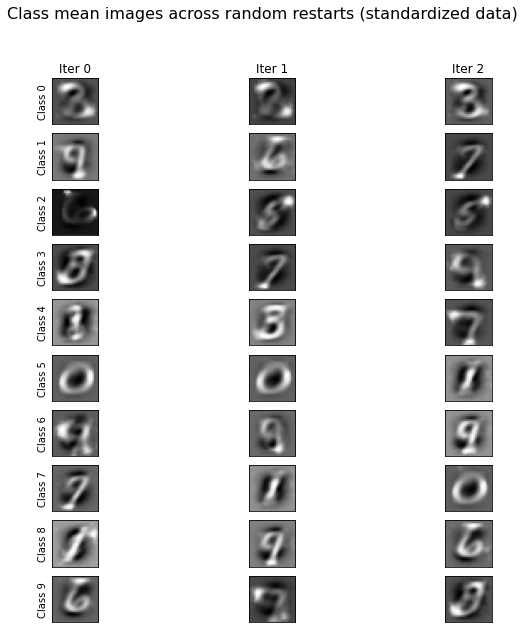

In [120]:
large_dataset_std = []
for j in range(large_dataset.shape[1]):
    data = large_dataset[:, j]
    mean = np.mean(data)
    std = np.std(data)
    if std == 0:
        large_dataset_std.append(data / 1)
    else:
        large_dataset_std.append((data - mean) / std)
large_dataset_std = np.transpose(np.array(large_dataset_std))  

make_mean_image_plot(large_dataset_std, standardized = True)

## HAC: Part 4

In [126]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.clusters = []
        self.history = [] # to track clusters for returning assignments at K clusters 
        self.min_distances = []
        self.X = None
    
    def fit(self, X):

        self.X = X

        def calculate_distance(c1, c2):
            cluster1 = np.array([X[index] for index in c1])
            cluster2 = np.array([X[index] for index in c2])
            d = distance.cdist(cluster1, cluster2, "euclidean")
            if self.linkage == "min":
                return np.min(d)
            elif self.linkage == "max":
                return np.max(d)
            else:
                centroid1 = np.mean(cluster1, axis=0)
                centroid2 = np.mean(cluster2, axis=0)
                return np.linalg.norm(centroid1 - centroid2)

        self.clusters = [{i} for i in range(len(X))]
        self.history = [self.clusters.copy()]

        while len(self.clusters) > 1:
            min_distance = float('inf')
            closest_clusters = None
            
            # Iterate through each pair of clusters 
            for i, cluster_i in enumerate(self.clusters):
                for j, cluster_j in enumerate(self.clusters):
                    if i != j:
                        distance_ij = calculate_distance(cluster_i, cluster_j)
                        if distance_ij < min_distance:
                            closest_clusters = (i,j)
                            min_distance = distance_ij
            
            # indices of clusters to merge
            i,j = closest_clusters
            
            # merge the two clusters 
            self.clusters[i] = self.clusters[i].union(self.clusters[j])
            
            # remove unmerged cluster from self.clusters
            self.clusters.remove(self.clusters[j])
            
            # update self.min_distances and self.history
            self.min_distances.append(min_distance)
            self.history.append(self.clusters.copy())

    # Returns the mean image when using n_clusters clusters
    def get_mean_images(self, n_clusters):
        cluster_indices = list(self.get_k_clusters(n_clusters))
        means = np.zeros((n_clusters, 784))
        for i, cluster in enumerate(cluster_indices):
            if cluster:
                cluster_images = np.array([self.X[idx] for idx in cluster])
                means[i] = np.mean(cluster_images, axis = 0)
        return means

    # Return assignments when there were K clusters
    def get_k_clusters(self, K):
        return self.history[-K]

    # Get cluster sizes to compare min and max linkage
    def get_cluster_sizes(self, K):
        clusters = self.history[-K]
        return [len(cluster) for cluster in clusters]

### Part 4: This takes ~6 minutes to run

Done: max
Done: min
Done: centroid


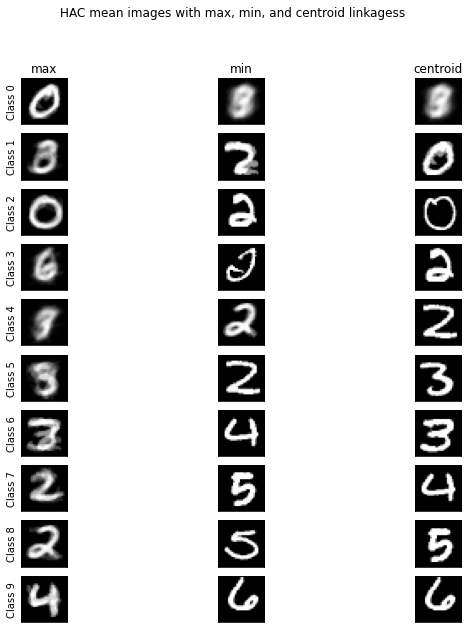

In [127]:
LINKAGES = [ 'max', 'min', 'centroid' ]
n_clusters = 10
cluster_sizes = []

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkagess")
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters)) # used in Part 8, append here to avoid re-fitting
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
    print("Done:", l)
plt.show()

### Part 5

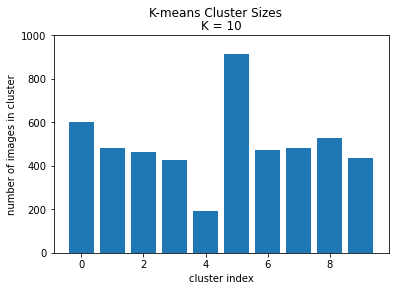

In [123]:
# Part 5: Create the graph for comparing cluster sizes in K-means
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes())

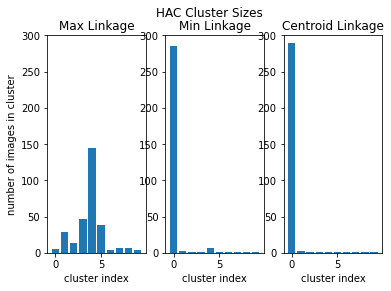

In [128]:
# Part 5: Create the graph for comparing cluster sizes in HAC
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes)

### Part 6: Confusion Matrix

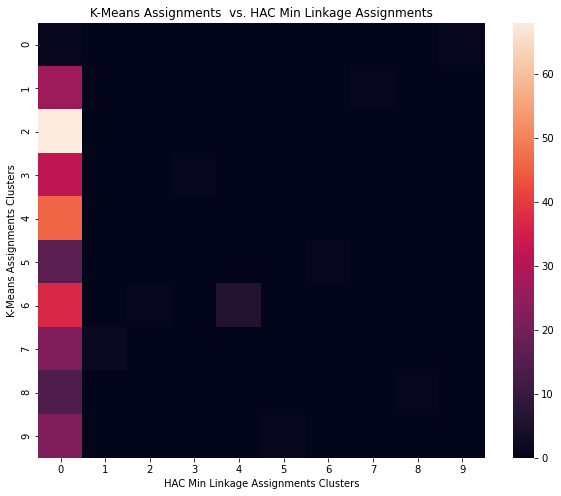

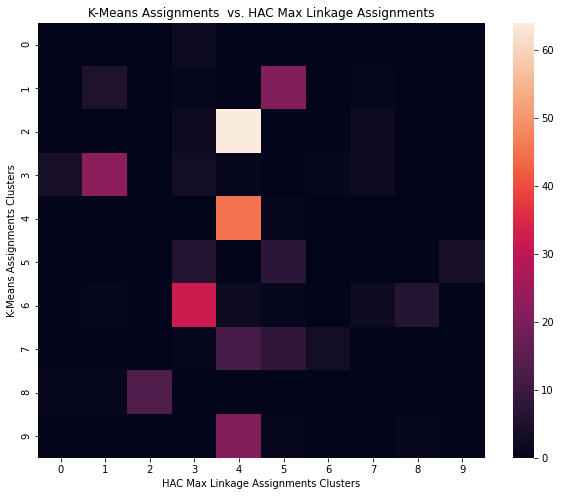

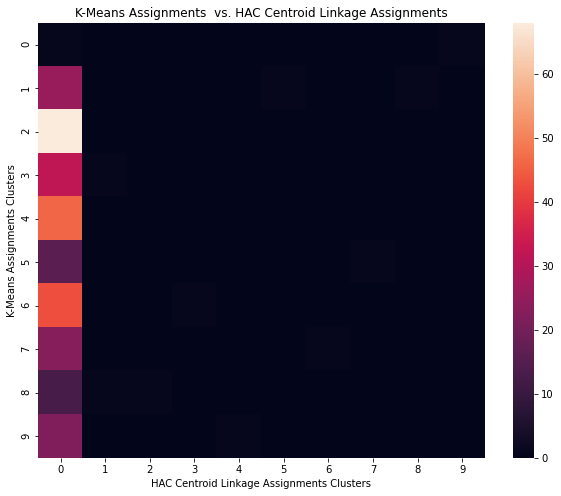

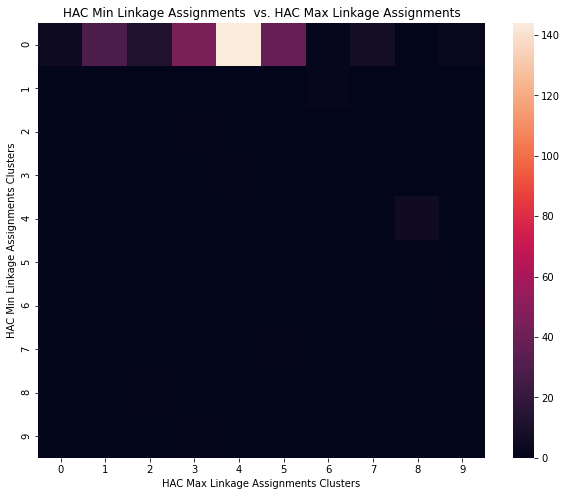

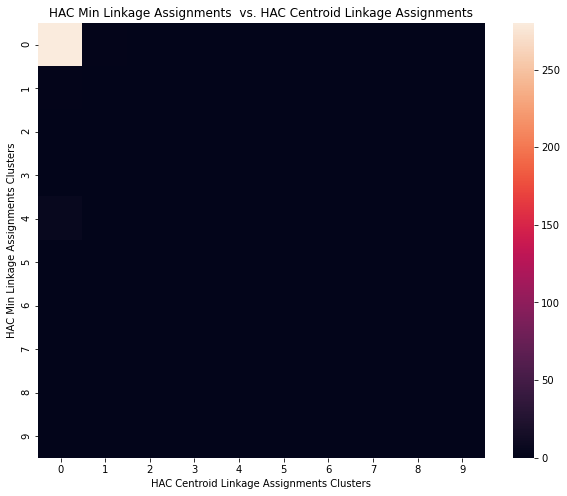

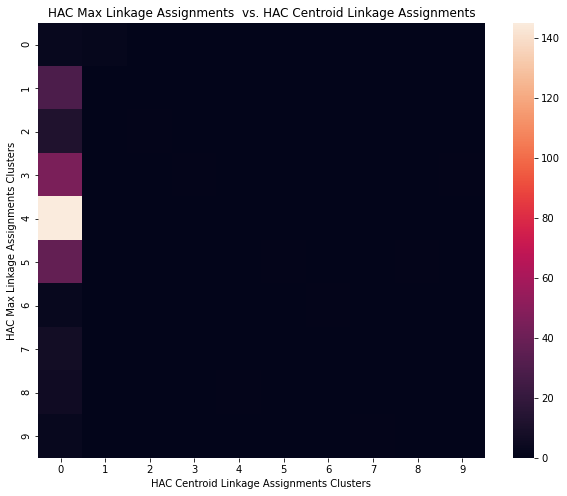

In [131]:
#setup
import itertools

def transform_cluster_assignments(clusters, num_points):
    assignments = np.zeros(num_points)
    for i, cluster in enumerate(clusters):
        for index in cluster:
            assignments[index] = i
    return assignments

def create_confusion_matrix(assignments1, assignments2):
    labels1 = np.unique(assignments1)
    labels2 = np.unique(assignments2)
    cm = np.zeros((len(labels1), len(labels2)), dtype=int)
    label_to_index1 = {label: index for index, label in enumerate(labels1)}
    label_to_index2 = {label: index for index, label in enumerate(labels2)}
    for label1, label2 in zip(assignments1, assignments2):
        index1 = label_to_index1[label1]
        index2 = label_to_index2[label2]
        cm[index1, index2] += 1
    return cm

def plot_confusion_matrix(cm, name1, name2):
    plt.figure(figsize=(10, 8))
    heatmap(cm) #annot=True, fmt='d', cmap='Blues'
    plt.title(f"{name1}  vs. {name2}")
    plt.xlabel(f"{name2} Clusters")
    plt.ylabel(f"{name1} Clusters")
    plt.show()

N = len(small_dataset)

#calculations
np.random.seed(42)
kmeans = KMeans(K = 10)
kmeans.fit(small_dataset)
kmeans_assignments = kmeans.assignments

hac_min = HAC(linkage = "min")
hac_min.fit(small_dataset)
min_assignments = transform_cluster_assignments(hac_min.get_k_clusters(10), N)

hac_max = HAC(linkage = "max")
hac_max.fit(small_dataset)
max_assignments = transform_cluster_assignments(hac_max.get_k_clusters(10), N)

hac_centroid = HAC(linkage = "centroid")
hac_centroid.fit(small_dataset)
centroid_assignments = transform_cluster_assignments(hac_centroid.get_k_clusters(10), N)

assignment_names = {
    'K-Means Assignments': kmeans_assignments,
    'HAC Min Linkage Assignments': min_assignments,
    'HAC Max Linkage Assignments': max_assignments,
    'HAC Centroid Linkage Assignments': centroid_assignments,
}
assignments = list(assignment_names.items())

for (name1, c1), (name2, c2) in list(itertools.combinations(assignments, 2)):
    cm = create_confusion_matrix(c1, c2)
    plot_confusion_matrix(cm, name1, name2)